In [1]:
%matplotlib inline


# Fundamental matrix estimation


This example demonstrates how to robustly estimate epipolar geometry between two
views using sparse ORB feature correspondences.

The fundamental matrix relates corresponding points between a pair of
uncalibrated images. The matrix transforms homogeneous image points in one image
to epipolar lines in the other image.

Uncalibrated means that the intrinsic calibration (focal lengths, pixel skew,
principal point) of the two cameras is not known. The fundamental matrix thus
enables projective 3D reconstruction of the captured scene. If the calibration
is known, estimating the essential matrix enables metric 3D reconstruction of
the captured scene.




/Users/robincole/anaconda3/lib/python3.6/site-packages/skimage/feature/match.py:49: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  if np.issubdtype(descriptors1.dtype, np.bool):


Number of matches: 223
Number of inliers: 163


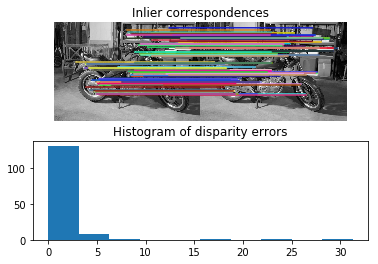

In [2]:
import numpy as np
from skimage import data
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, ORB, plot_matches
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform
import matplotlib.pyplot as plt

np.random.seed(0)

img_left, img_right, groundtruth_disp = data.stereo_motorcycle()
img_left, img_right = map(rgb2gray, (img_left, img_right))

# Find sparse feature correspondences between left and right image.

descriptor_extractor = ORB()

descriptor_extractor.detect_and_extract(img_left)
keypoints_left = descriptor_extractor.keypoints
descriptors_left = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img_right)
keypoints_right = descriptor_extractor.keypoints
descriptors_right = descriptor_extractor.descriptors

matches = match_descriptors(descriptors_left, descriptors_right,
                            cross_check=True)

# Estimate the epipolar geometry between the left and right image.

model, inliers = ransac((keypoints_left[matches[:, 0]],
                         keypoints_right[matches[:, 1]]),
                        FundamentalMatrixTransform, min_samples=8,
                        residual_threshold=1, max_trials=5000)

inlier_keypoints_left = keypoints_left[matches[inliers, 0]]
inlier_keypoints_right = keypoints_right[matches[inliers, 1]]

print("Number of matches:", matches.shape[0])
print("Number of inliers:", inliers.sum())

# Compare estimated sparse disparities to the dense ground-truth disparities.

disp = inlier_keypoints_left[:, 1] - inlier_keypoints_right[:, 1]
disp_coords = np.round(inlier_keypoints_left).astype(np.int64)
disp_idxs = np.ravel_multi_index(disp_coords.T, groundtruth_disp.shape)
disp_error = np.abs(groundtruth_disp.ravel()[disp_idxs] - disp)
disp_error = disp_error[np.isfinite(disp_error)]

# Visualize the results.

fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

plot_matches(ax[0], img_left, img_right, keypoints_left, keypoints_right,
             matches[inliers], only_matches=True)
ax[0].axis("off")
ax[0].set_title("Inlier correspondences")

ax[1].hist(disp_error)
ax[1].set_title("Histogram of disparity errors")

plt.show()